# BAFIA
## arXiv:2103.10601

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
G = 150

def Rs(Q):
    return G/Q

def Xs(f, f0, X0):
    return -2*G*(f-f0)/f0+X0

def sigmaRX(Rs, Xs, freq0):

    omega = 2*np.pi*freq0
    mu0= const.mu_0
    
    sigma = omega*mu0*(2*Rs*Xs/(Rs**2+Xs**2)**2 + (Xs**2-Rs**2)/(Rs**2+Xs**2)**2*1j)
    
    sigma1 = np.real(sigma)
    sigma2 = np.imag(sigma)

    return sigma1, sigma2, sigma

def sigmaTrunin(Rs, Xs, Rn):
    
    sigma1 = 4*Rn**2*Rs*Xs/(Rs**2+Xs**2)**2
    
    sigma2 = 2*Rn**2*(Xs**2-Rs**2)/(Rs**2+Xs**2)**2

    return sigma1, sigma2, (sigma1+1j*sigma2)
    

In [2]:
fileName = "20250128_FNAL_103.txt"
data = np.loadtxt(fileName, skiprows=4)
temp = data[:,1]
freq = data[:,5]
Q0 = data[:,6]
temp = np.delete(temp, np.where(freq == freq.min()))
freq = np.delete(freq, np.where(freq == freq.min()))
Q0 = np.delete(Q0, np.where(freq == freq.min()))
idx = np.where((temp <= 9) & (temp>=0.1*9.2) )
RsData = Rs(Q0[idx])
sigman = G/Q0[idx[0][0]]
print(sigman)
# Rn(10K) = Xn(10K)
XsData = Xs(freq[idx], freq[np.min(idx)]+11e3, sigman)

sigma1, sigma2, sigma = sigmaRX(RsData, XsData, freq[np.min(idx)])
sigma1T, sigma2T, sigmaT = sigmaTrunin(RsData, XsData, sigman)

0.003629375614559148


(4.0, 11.0)

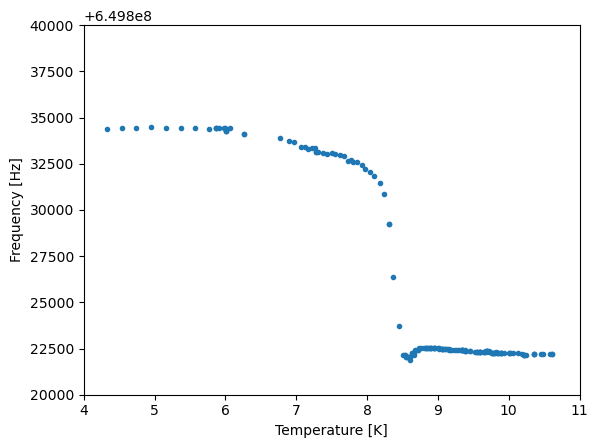

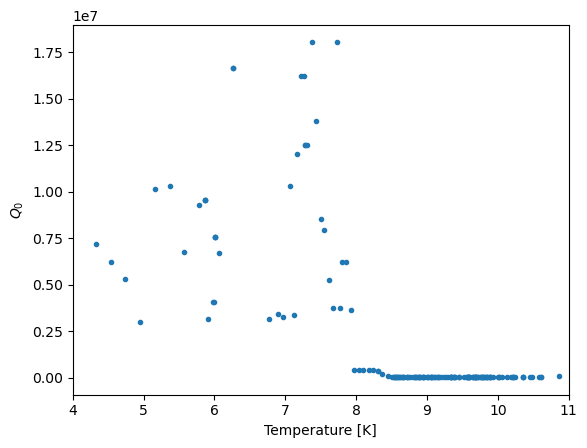

In [3]:
plt.figure()
plt.plot(temp, freq,'.')
plt.xlabel('Temperature [K]')
plt.ylabel('Frequency [Hz]')
plt.xlim([4, 11])
plt.ylim([6.4982e8, 6.4984e8])
plt.figure()
plt.plot(temp, Q0,'.')
plt.xlabel('Temperature [K]')
plt.ylabel('$Q_0$')
plt.xlim([4, 11])

In [4]:
import SCconductivity  as sc
freqS = 650e6
Tc = 8.7
tempS = np.linspace(2, Tc-1e-3, 1000)
Gamma = 0.06
sigman =  1/(152e-9*1e-2)
G = 192
Rr = 4e-9

def deltaLambda(freq, temp, G= 192):
        f0 = freq[np.where(temp<=5.0)[0][0]]
        dL = -G*(freq-f0)/(const.pi*const.mu_0*f0**2)
        return dL

mySc = sc.SCconductivity(Tc, freqS, Gamma, tempS, sigman)

Q = mySc.Q()
deltaf = mySc.deltaf()
ZsS = mySc.Zs()
s1S, s2S = mySc.sigma()

c:\Users\sertore\OneDrive - Istituto Nazionale di Fisica Nucleare\code\Python\FreqBump\SCconductivity.py:25: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(E/(self.k*T)))


[[Model]]
    Model(deltaLFit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 50
    # variables        = 4
    chi-square         = 70040997.6
    reduced chi-square = 1522630.38
    Akaike info crit   = 715.628415
    Bayesian info crit = 723.276507
    R-squared          = 0.56654844
[[Variables]]
    Tc:       8.60081895 +/- 0.32414787 (3.77%) (init = 8.7)
    lLondon:  1005.05093 +/- 4.2568e+14 (42354235000388.34%) (init = 500)
    l:        599.637993 +/- 2.5012e+17 (41711700207954296.00%) (init = 600)
    eps:      600 (fixed)
    l0:       315.204749 +/- 76647.8634 (24316.85%) (init = 600)
[[Correlations]] (unreported correlations are < 0.100)
    C(lLondon, l)  = -1.0000
    C(Tc, l0)      = -0.9193
    C(Tc, l)       = +0.2563
    C(Tc, lLondon) = -0.2563
    C(l, l0)       = -0.2053
    C(lLondon, l0) = +0.2053


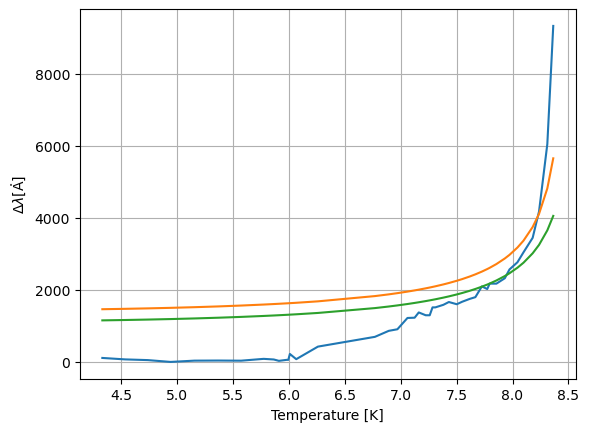

In [29]:
idx1 = np.where((temp <= Tc-0.3) & (temp>=0.1*9.2) )
deltaL = deltaLambda(freq[idx1], temp[idx1])
from scipy.optimize import curve_fit
fig = plt.subplot()
plt.plot(temp[idx1], deltaL*1e10)
plt.xlabel("Temperature [K]")
plt.ylabel("$\Delta \lambda [\mathring {\mathrm {A}}]$")
plt.grid('both')

def deltaLFit(temp, Tc, lLondon, l, eps, l0):
    dl = lLondon*np.sqrt(1+eps/l)*1/np.sqrt(1-(temp/Tc)**4)-l0
    return dl



plt.plot(temp[idx1], deltaLFit(temp[idx1], Tc-0.2, 1000, 1, 1, 0 ))

# para, cov = curve_fit(deltaLFit, temp[idx], deltaL*1e10, p0=[Tc-0.2, 1000, 100, 200, 0.1], 
#                        maxfev=50000, ftol=1e-1, xtol=1e-1, full_output=True)

from lmfit import Model, Parameters

gmodel = Model(deltaLFit)
params = Parameters()
params.add('Tc', min = 8.6, max = 8.9, value = Tc)
params.add('lLondon', min = 100, max = 2000, value = 500)
params.add('l', min = 400, max = 600, value = 600)
params.add('eps', min = 0.1, max = 600, value = 620, vary = False)
params.add('l0', min = 100, max = 600, value = 610)
tEmp = temp[idx1]
result = gmodel.fit(deltaL*1e10, temp = tEmp, params=params)

print(result.fit_report())   
plt.plot(temp[idx1], result.best_fit) 
plt.show()
# plt.xlim([7,10])
# plt.ylim([0, 2e-6])


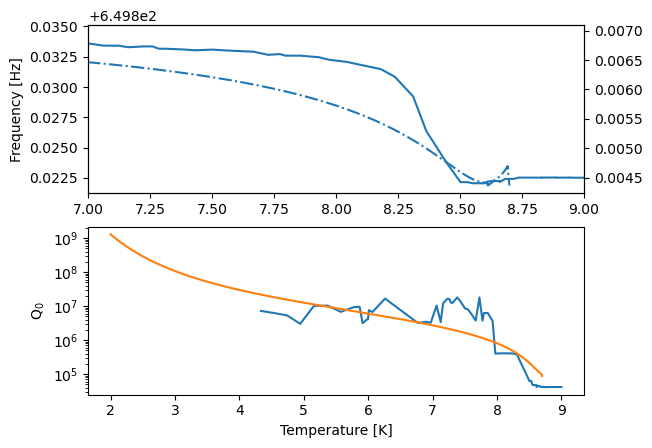

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(temp[idx],freq[idx]/1e6)
ax[0].set_xlim([7, 9])
ax1 = ax[0].twinx()
ax1.plot(tempS, deltaf/1e6,'-.')
ax1.set_xlim([7,9])
ax[0].set_ylabel(r"Frequency [Hz]")
ax[1].semilogy(temp[idx],Q0[idx])
ax[1].semilogy(tempS, Q, '-')
ax[1].set_ylabel(r"Q$_0$")
ax[1].set_xlabel('Temperature [K]');

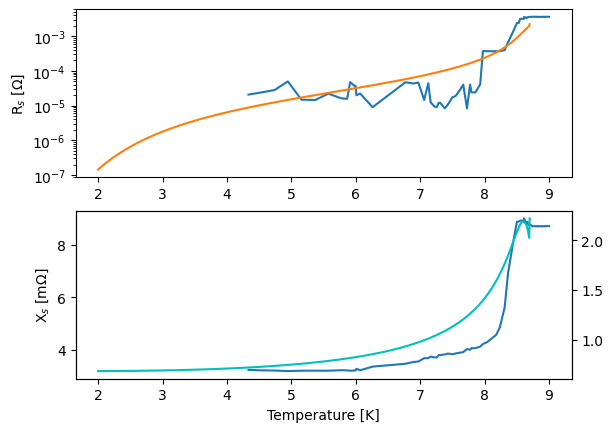

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].semilogy(temp[idx],RsData)
ax[0].semilogy(tempS, np.real(ZsS))
ax[0].set_ylabel(r"R$_s$ [$\Omega$]")
ax[1].plot(temp[idx],XsData/1e-3)
ax1 = ax[1].twinx()
ax1.plot(tempS, np.imag(ZsS)/1e-3,'c')
ax[1].set_ylabel(r"X$_s$ [m$\Omega$]")
ax[1].set_xlabel('Temperature [K]');

c:\Users\sertore\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sertore\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


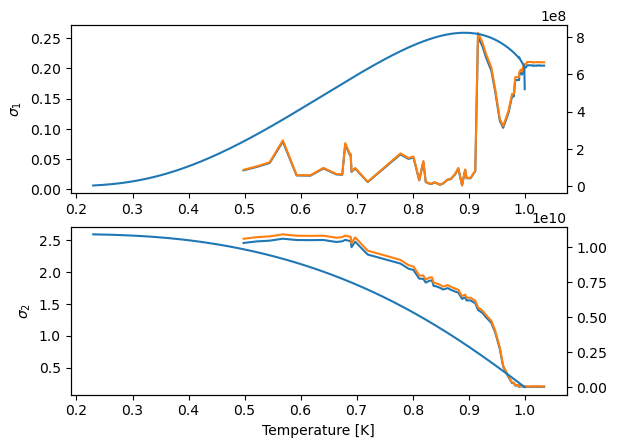

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(temp[idx]/Tc,sigma1/2e8)
ax[0].plot(temp[idx]/Tc,sigma1T)
ax0 = ax[0].twinx()
ax0.plot(tempS/Tc, s1S)
ax[0].set_ylabel(r"$\sigma_1$")
ax[1].plot(temp[idx]/Tc,sigma2/2e8)
ax[1].plot(temp[idx]/Tc,sigma2T)
ax1 = ax[1].twinx()
ax1.plot(tempS/Tc, s2S)
ax[1].set_ylabel(r"$\sigma_2$")
ax[1].set_xlabel('Temperature [K]');